#### 1) Imports and Random Seed


In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import torchvision.models as models
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


In [2]:
!pip install pot


Make sure to put https://github.com/zijianchen98/AGIN/blob/main/JOINT/models/JOINT.py in the same directory as this notebook


In [3]:
import sys
import JOINT


In [4]:
import random
import numpy as np
import torch

SEED = 78
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


#### 2) Defining the Dataset


In [5]:
class ImageRatingDataset(Dataset):

    def __init__(self, dataframe, transform=None, augment=False, phase=""):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        self.augment = augment
        self.phase = phase

        # Define augmentations
        self.augmentation = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10),  # small rotations
                transforms.RandomResizedCrop(
                    size=(384, 512), scale=(0.9, 1.0), ratio=(1.25, 1.35)
                ),
                transforms.ColorJitter(brightness=0.1, contrast=0.1),  # light changes
            ]
        )

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, "filename"]
        rating = self.dataframe.loc[idx, "MOS"]

        if self.phase == "train":
            image = Image.open("../../dataset/images/train_images/" + img_path).convert(
                "RGB"
            )
        elif self.phase == "test":
            image = Image.open("../../dataset/images/test_images/" + img_path).convert(
                "RGB"
            )

        if self.augment == True:
            image = self.augmentation(image)
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(rating, dtype=torch.float32)


#### 3) Create Model


In [6]:
class ResNetRegressor(nn.Module):
    def __init__(self):
        super(ResNetRegressor, self).__init__()

        self.model = JOINT.JOINT_Model()

        # TODO: Get the checkpoint from the AGIN repo (it's in the README)

        # Here's the direct link to their weights:
        # https://onedrive.live.com/?redeem=aHR0cHM6Ly8xZHJ2Lm1zL3UvYy8wYzIxOTFjYjAxY2JmMDAyL0VjX2xuY0N4R1paQ25qb2NUNDAtc24wQjVTcmcwekZuNkgtOTVFb3B2eEpJelE%5FZT10YWlUOVI&cid=0C2191CB01CBF002&id=C2191CB01CBF002%21sc09de5cf19b142969e3a1c4f8d3eb27d&parId=C2191CB01CBF002%21s10403dccf95e47979e25d26520e84d7b&o=OneUp

        # Create a directory called `jointweights` and save the .pth file there.
        if torch.cuda.is_available():
            self.model.load_state_dict(torch.load("./jointweights/JOINT_2024.pth"))
        else:
            self.model.load_state_dict(
                torch.load(
                    "./jointweights/JOINT_2024.pth", map_location=torch.device("cpu")
                )
            )

        # Get the feature extractor
        self.features = nn.Sequential(
            *list(self.model.rationality_feature_extraction.children())
        )[:-1]

        # Freeze base layers
        for param in self.features.parameters():
            param.requires_grad = False

        # Add a custom regression head
        self.regressor = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)  # Output shape: (batch_size, 512, 1, 1)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 512)
        x = self.regressor(x)
        x = x.view(x.size(0), -1)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetRegressor().to(device)


/var/folders/l4/8h7869116bj2w59cq06rwl8c0000gn/T/ipykernel_42547/1856411903.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


In [7]:
# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


num_params = count_parameters(model)
print(f"Total number of trainable parameters: {num_params:,}")


Total number of trainable parameters: 32,582,501


#### 4) Loading the Data


In [8]:
test_df = pd.read_csv("../../dataset/ratings/test.csv")
print(test_df.shape)


(90, 2)


In [9]:
test_dataset = ImageRatingDataset(test_df, phase="test")
test_loader = DataLoader(test_dataset, batch_size=32)


#### 5) Loading the Model Weights


In [13]:
checkpoint_path = "./weights/resnet50_joint-weights.pth"

if torch.cuda.is_available():
    model.load_state_dict(torch.load(checkpoint_path))
else:
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device("cpu")))


/var/folders/l4/8h7869116bj2w59cq06rwl8c0000gn/T/ipykernel_42547/3693531072.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_p

#### 6) Evaluating on Test set


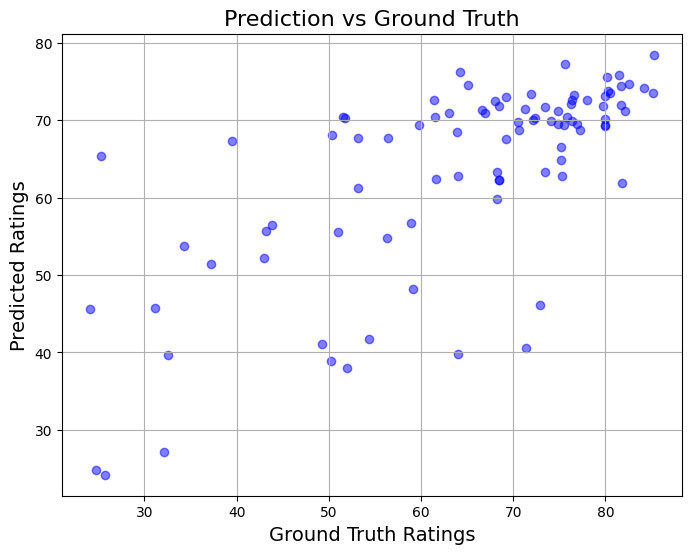

0.6784623616084289 0.702721


In [ ]:
model.eval()
predictions = []
ground_truths = []
# Iterate over the validation dataset
with torch.no_grad():
    for images, ratings in test_loader:
        images = images.to(device)  # Move to device (GPU or CPU)
        ratings = ratings.to(device)

        # Get predictions from the model
        predicted_ratings = model(images)

        # Append predicted and ground truth values to the lists
        predictions.extend(predicted_ratings.cpu().numpy())  # move to CPU and convert to numpy
        ground_truths.extend(ratings.cpu().numpy())  # move to CPU and convert to numpy

# Convert lists to numpy arrays
predictions = np.array(predictions).flatten()
ground_truths = np.array(ground_truths).flatten()

# # denormalize
predictions = predictions
ground_truths = ground_truths 

# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(ground_truths, predictions, alpha=0.5, c='blue')
plt.title('Prediction vs Ground Truth', fontsize=16)
plt.xlabel('Ground Truth Ratings', fontsize=14)
plt.ylabel('Predicted Ratings', fontsize=14)
plt.grid(True)
plt.show()

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(ground_truths, predictions)
pearson_corr, _ = pearsonr(ground_truths, predictions)

print(spearman_corr, pearson_corr)
